In [10]:
import numpy as np
import glob
import zipfile
import datetime as dt
import xarray as xr
import tobac
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
%matplotlib inline

def unpack_level1b(rid, times):
        #Unzip level1b data between times[0] and times[1], and save to scratch
        assert times[0].year == times[1].year, "Times range must be within calendar year"
        files = np.array(glob.glob("/g/data/rq0/level_1b/"+rid+"/grid/"+str(times[0].year)+"/*.zip"))
        if len(files) == 0:
                print("NO FILES FOUND FOR RID: "+rid+" AND TIMES "+times[0].strftime("%Y%m%d %H:%M")+" "+times[-1].strftime("%Y%m%d %H:%M"))
        file_dates = np.array([dt.datetime.strptime(f.split("/")[8].split("_")[1], "%Y%m%d") for f in files])
        target_files = files[(file_dates >= times[0].replace(hour=0, minute=0)) & (file_dates <= times[1].replace(hour=0, minute=0))]
        extract_to = "/scratch/w40/ab4502/tint/"
        for f in target_files:
                with zipfile.ZipFile(f, "r") as zip_ref:
                        zip_ref.extractall(extract_to)

In [11]:
#Define times and radar ID
rid="49"
times=[dt.datetime(2011,9,28,9,20),dt.datetime(2011,9,28,9,25)]

In [12]:
#Load the radar data with xarray

outname = rid+"_"+times[0].strftime("%Y%m%d")
unpack_level1b(rid, times)
grid_files = np.sort(glob.glob("/scratch/w40/ab4502/tint/"+rid+"*_grid.nc"))
file_dates = np.array([dt.datetime.strptime(f.split("/")[5].split("_")[1] + f.split("/")[5].split("_")[2],\
                "%Y%m%d%H%M%S") for f in grid_files])
target_files = grid_files[(file_dates >= times[0]) & (file_dates <= times[1])]

grid_ds=xr.open_dataset(target_files[0])

In [13]:
field = "corrected_reflectivity"
grid_ds[field]

<xarray.DataArray 'corrected_reflectivity' (time: 1, z: 41, y: 301, x: 301)>
[3714641 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2011-09-28T09:22:21
  * x        (x) float64 -1.5e+05 -1.49e+05 -1.48e+05 ... 1.49e+05 1.5e+05
  * y        (y) float64 -1.5e+05 -1.49e+05 -1.48e+05 ... 1.49e+05 1.5e+05
  * z        (z) float64 0.0 500.0 1e+03 1.5e+03 ... 1.9e+04 1.95e+04 2e+04
Attributes:
    calibration_offset:       -5.07
    calibration_units:        dBZ
    calibration_description:  Technique implemented using satellite matching ...
    calibration_comment:      GR_cal = GR - cal_offset
    comment:                  Radar reflectivity has not been corrected for w...

In [14]:
#Do the tobac segmentation
grid_size = grid_ds.attrs["grid_horz_resolution_m"]

#Take column max - for segmentation
colmax = grid_ds[field].max("z")

#Need to do some messing around to get to an Iris cube object
for n in colmax.coords:
    if n not in ["time","x","y"]:
        colmax = colmax.drop(n)
colmax = colmax.where(~colmax.isnull(),0).to_iris()

#Set feature identification parameters
parameters_features={}
parameters_features['position_threshold']='extreme'
parameters_features['sigma_threshold']=3
parameters_features['threshold']=[30,40]
parameters_features['n_erosion_threshold']=0

#Set segmentation parameters
parameters_segmentation={}
parameters_segmentation['threshold']=30
parameters_segmentation['sigma_threshold']=3

Features=tobac.feature_detection.feature_detection_multithreshold(colmax,grid_size,**parameters_features)
Mask_refl,Features=tobac.segmentation.segmentation(Features,colmax,grid_size,**parameters_segmentation)

#I use an edited verstion of "clear_small_echoes" from TINT
#frame=clear_small_echoes(Mask_refl.data, masked.data, min_size, min_vol, min_height, params['FIELD_THRESH'], params["MIN_FIELD"])

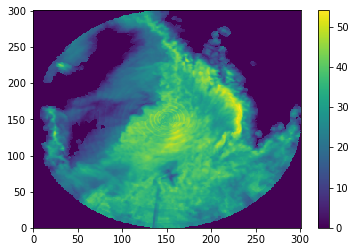

In [15]:
#Plot raw reflectivity
plt.pcolormesh(colmax.data.squeeze())
plt.colorbar()

Text(0.5, 1.0, 'Features w/30 dBZ contour (uses smoothing option)')

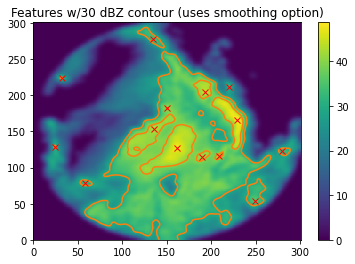

In [16]:
#Plot the smoothed reflectivity, as seen by tobac, and the corresponding threshold/mask
plt.figure()
plt.pcolormesh(gaussian_filter(colmax.data[0],parameters_features['sigma_threshold'])); plt.colorbar()
plt.plot(Features.hdim_2, Features.hdim_1, ls="none",marker="x",color="red")    
plt.contour(gaussian_filter(colmax.data[0],parameters_features['sigma_threshold']),levels=parameters_features['threshold'],colors="tab:orange")   
plt.title("Features w/30 dBZ contour (uses smoothing option)")

Text(0.5, 1.0, 'Segmentation and removing small/weak (less than 30 dBZ max) objects')

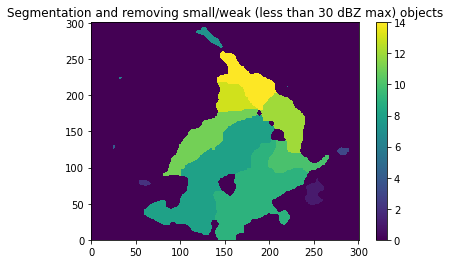

In [17]:
#Plot the objects identified by tobac
plt.figure()
plt.pcolormesh(Mask_refl.data)
plt.colorbar()
plt.title("Segmentation and removing small/weak (less than 30 dBZ max) objects")

In [ ]:
#I don't do tracking with tobac. See example here for what tracking code looks like:
#https://github.com/tobac-project/tobac/blob/main/examples/Example_OLR_Tracking_satellite/Example_OLR_Tracking_satellite.ipynb

#I made small changes to the segmentation code so that it uses the smoothed data:
#https://github.com/andrewbrown31/tobac/commit/77282f82cee297a19921f8172aa3c2e965ad069c